# Import libraries

In [2]:
%pip install --force-reinstall tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.8/114.8 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.0/227.0 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 1.8 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 6.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 9.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 9.6 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.8/389.8 kB 7.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 10.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4

In [1]:
#Import dependencies
import numpy as np
import pandas as pd 
import seaborn as sns
import os as os
import matplotlib.pyplot as plt
import calendar

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate

# Import dataframes

In [2]:
# Load the data
df = pd.read_csv('input/cybersecurity_attacks.csv')
print("Data loaded successfully")
df.head()

Data loaded successfully


,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,...,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,...,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,...,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro l...,...,Blocked,Medium,Fateh Kibe,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; ...,Segment B,"Jaunpur, Rajasthan",NaN,NaN,Alert Data,Firewall
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi v...,...,Blocked,Low,Dhanush Chad,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,Segment C,"Anantapur, Tripura",149.6.110.119,NaN,Alert Data,Firewall


In [35]:
sorted_df = df.sort_values(by='Timestamp')
sorted_df[['Timestamp','Anomaly Scores']].head(50)

,Timestamp,Anomaly Scores
17494,2020-01-01 00:43:27,40.63
33427,2020-01-01 01:14:07,43.01
26028,2020-01-01 03:02:42,41.29
38419,2020-01-01 03:11:48,46.70
29339,2020-01-01 03:29:20,99.78
1867,2020-01-01 04:19:53,25.86
8951,2020-01-01 04:30:19,54.24
28783,2020-01-01 05:17:19,66.70
21778,2020-01-01 05:21:39,60.74
39660,2020-01-01 06:37:14,45.28


In [36]:
scores = sorted_df['Anomaly Scores'].reset_index().drop(columns=['index'])

In [37]:
print(scores)

       Anomaly Scores
0               40.63
1               43.01
2               41.29
3               46.70
4               99.78
...               ...
39995           30.28
39996            2.02
39997           90.61
39998           63.98
39999           46.91

[40000 rows x 1 columns]


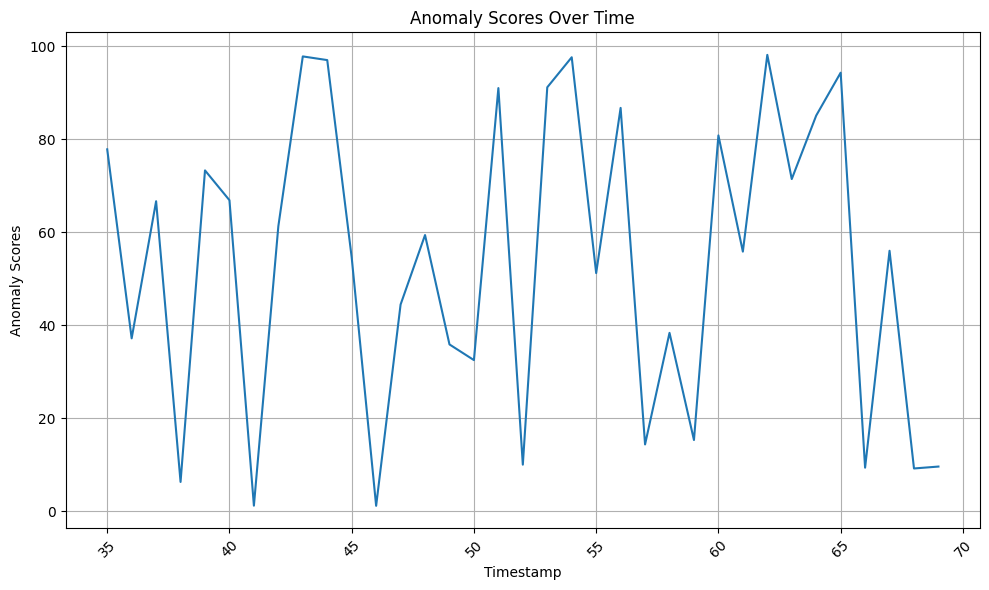

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(scores[35:70])
plt.title('Anomaly Scores Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Anomaly Scores')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Info on the dataframes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Timestamp               40000 non-null  object 
 1   Source IP Address       40000 non-null  object 
 2   Destination IP Address  40000 non-null  object 
 3   Source Port             40000 non-null  int64  
 4   Destination Port        40000 non-null  int64  
 5   Protocol                40000 non-null  object 
 6   Packet Length           40000 non-null  int64  
 7   Packet Type             40000 non-null  object 
 8   Traffic Type            40000 non-null  object 
 9   Payload Data            40000 non-null  object 
 10  Malware Indicators      20000 non-null  object 
 11  Anomaly Scores          40000 non-null  float64
 12  Alerts/Warnings         19933 non-null  object 
 13  Attack Type             40000 non-null  object 
 14  Attack Signature        40000 non-null

In [4]:
print(df.shape)

(40000, 25)


In [5]:
df.columns


Index(['Timestamp', 'Source IP Address', 'Destination IP Address',
       'Source Port', 'Destination Port', 'Protocol', 'Packet Length',
       'Packet Type', 'Traffic Type', 'Payload Data', 'Malware Indicators',
       'Anomaly Scores', 'Alerts/Warnings', 'Attack Type', 'Attack Signature',
       'Action Taken', 'Severity Level', 'User Information',
       'Device Information', 'Network Segment', 'Geo-location Data',
       'Proxy Information', 'Firewall Logs', 'IDS/IPS Alerts', 'Log Source'],
      dtype='object')

In [6]:
def plot_density(df):
    fig, ax = plt.subplots(2, 1, figsize=(7, 5))

    sns.kdeplot(df['Anomaly Scores'], color='skyblue', linewidth=3, ax=ax[0])
    ax[0].set_title('Distribution of Values')
    ax[0].set_xlabel('Value')
    ax[0].set_ylabel('Density')
    ax[0].set_ylim(0.005,0.0105)
    ax[0].grid(True)

    value_counts = df['Anomaly Scores'].value_counts().sort_index().reindex(range(101), fill_value=0)
    value_counts.index *= 100
    summed_counts = value_counts.groupby(pd.cut(value_counts.index, bins=range(0, 10001, 500))).sum()

    ax[1].bar([interval.right for interval in summed_counts.index], summed_counts.values, color='skyblue', width=500)
    ax[1].set_title('Value Counts for each 5%')
    ax[1].set_xlabel('Value')
    ax[1].set_ylabel('Frequency')
    ax[1].grid(axis='y')
    ax[1].set_xlim(1000,10000)

    plt.tight_layout()

    plt.show()
    
    print(summed_counts)
    
def plot_features_vals_density(df, column):
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    vals_names = np.unique(df[column])
    sns.kdeplot(data=df, x='Anomaly Scores', hue=column, fill=True, common_norm=False, palette='tab10', ax=ax, label=vals_names)
    
    ax.set_title('Distribution of Anomaly Scores by {}'.format(column))
    ax.set_xlabel('Anomaly Scores')
    ax.set_ylabel('Density')
    ax.set_ylim(0.009, 0.0109)
    ax.grid(True)
    ax.legend(title=column)
    
    plt.tight_layout()
    plt.show()
    
def plot_correlation(df,f_column):
    fig, ax = plt.subplots(1, 2, figsize=(10, 6))
    sns.boxplot(x=f_column, y='Anomaly Scores', data=df, ax=ax[0])
    ax[0].set_title(f'Effect of {f_column} on Anomaly Scores (Box Plot)')
    ax[0].grid(True)

    sns.violinplot(x=f_column, y='Anomaly Scores', data=df,ax=ax[1])
    ax[1].set_title(f'Effect of {f_column} on Anomaly Scores(Violin Plot)')
    ax[1].grid(True)
    plt.show()
    
def plot_scatter(df, f_column):
    plt.figure(figsize=(8, 6))
    plt.scatter(df[f_column], df['Anomaly Scores'], color='blue', label='Data points')
    plt.xlabel(f_column)
    plt.ylabel('anomaly scores')
    plt.title(f'Correlation Between {f_column} and Anomaly Scores')
    plt.legend()
    plt.grid(True)
    plt.show()

9826


/var/folders/ms/lx6k291d71z8f387pwx9g8cm0000gn/T/ipykernel_1504/2337017160.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summed_counts = value_counts.groupby(pd.cut(value_counts.index, bins=range(0, 10001, 500))).sum()


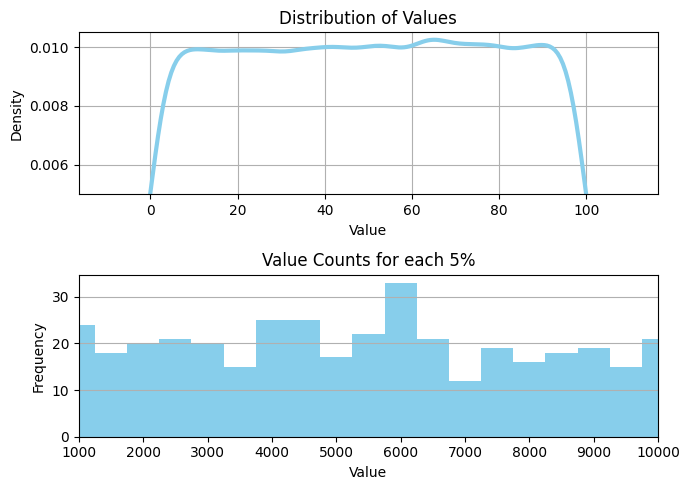

(0, 500]         26
(500, 1000]      24
(1000, 1500]     18
(1500, 2000]     20
(2000, 2500]     21
(2500, 3000]     20
(3000, 3500]     15
(3500, 4000]     25
(4000, 4500]     25
(4500, 5000]     17
(5000, 5500]     22
(5500, 6000]     33
(6000, 6500]     21
(6500, 7000]     12
(7000, 7500]     19
(7500, 8000]     16
(8000, 8500]     18
(8500, 9000]     19
(9000, 9500]     15
(9500, 10000]    21
Name: count, dtype: int64


In [7]:
print(len(sorted(np.unique(df['Anomaly Scores']))))
plot_density(df)

# Preprocessing

## Handling None Columns

In [28]:
print(f'drop nones: {len(df)} -> {len(df.dropna())}')

drop nones: 40000 -> 1237


In [29]:
df.isnull().sum()

Timestamp                     0
Source IP Address             0
Destination IP Address        0
Source Port                   0
Destination Port              0
Protocol                      0
Packet Length                 0
Packet Type                   0
Traffic Type                  0
Payload Data                  0
Malware Indicators        20000
Anomaly Scores                0
Alerts/Warnings           20067
Attack Type                   0
Attack Signature              0
Action Taken                  0
Severity Level                0
User Information              0
Device Information            0
Network Segment               0
Geo-location Data             0
Proxy Information         19851
Firewall Logs             19961
IDS/IPS Alerts            20050
Log Source                    0
dtype: int64

In [30]:
none_cols = ['Malware Indicators','Alerts/Warnings','Proxy Information','Firewall Logs','IDS/IPS Alerts']

for col in none_cols:
    print(f'''
{df[col].value_counts()}
- pos. vals.:
{df[col].astype(str).unique()}
          ''')


Malware Indicators
IoC Detected    20000
Name: count, dtype: int64
- pos. vals.:
['IoC Detected' 'nan']
          

Alerts/Warnings
Alert Triggered    19933
Name: count, dtype: int64
- pos. vals.:
['nan' 'Alert Triggered']
          

Proxy Information
39.123.165.122     2
150.9.97.135       1
198.80.71.196      1
108.143.243.168    1
211.195.173.251    1
                  ..
205.112.169.158    1
78.192.52.63       1
157.191.153.187    1
205.183.87.116     1
112.169.115.139    1
Name: count, Length: 20148, dtype: int64
- pos. vals.:
['150.9.97.135' 'nan' '114.133.48.179' ... '60.51.30.46' '137.76.130.8'
 '112.169.115.139']
          

Firewall Logs
Log Data    20039
Name: count, dtype: int64
- pos. vals.:
['Log Data' 'nan']
          

IDS/IPS Alerts
Alert Data    19950
Name: count, dtype: int64
- pos. vals.:
['nan' 'Alert Data']
          


In [31]:
df['Malware Indicators'].replace('IoC Detected', 1, inplace=True)
df['Malware Indicators'].fillna(0, inplace=True)

df['Alerts/Warnings'].replace('Alert Triggered', 1, inplace=True)
df['Alerts/Warnings'].fillna(0, inplace=True)

df['Proxy Information'].fillna(0, inplace=True)
#df.loc[df['Proxy Information'] != 0, 'Proxy Information'] = 1

df['Firewall Logs'].replace('Log Data', 1, inplace=True)
df['Firewall Logs'].fillna(0, inplace=True)

df['IDS/IPS Alerts'].replace('Alert Data', 1, inplace=True)
df['IDS/IPS Alerts'].fillna(0, inplace=True)

/var/folders/ms/lx6k291d71z8f387pwx9g8cm0000gn/T/ipykernel_1390/1037095925.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Malware Indicators'].replace('IoC Detected', 1, inplace=True)
/var/folders/ms/lx6k291d71z8f387pwx9g8cm0000gn/T/ipykernel_1390/1037095925.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_dow

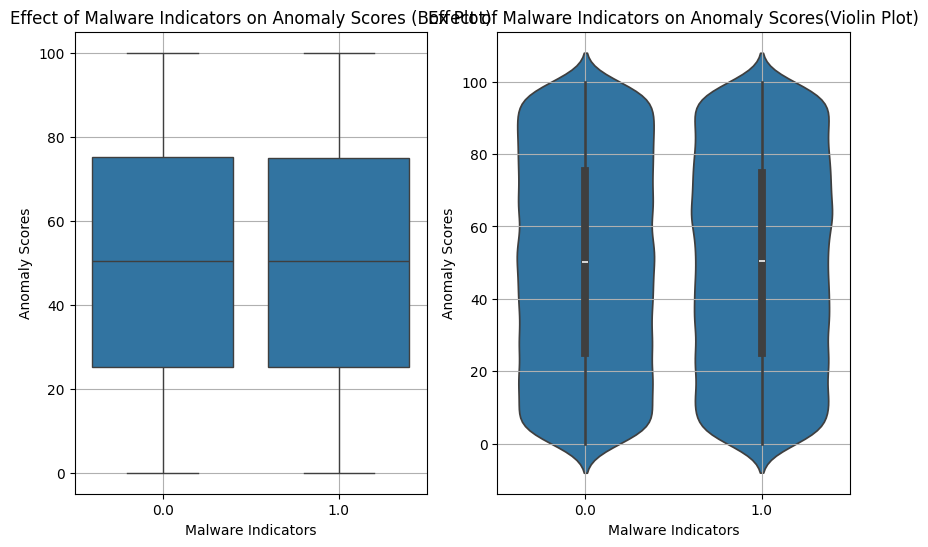

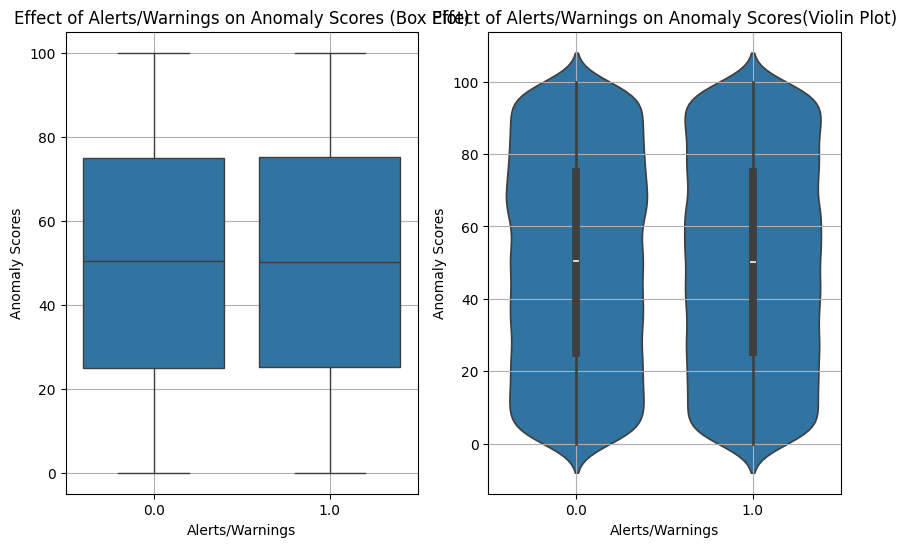

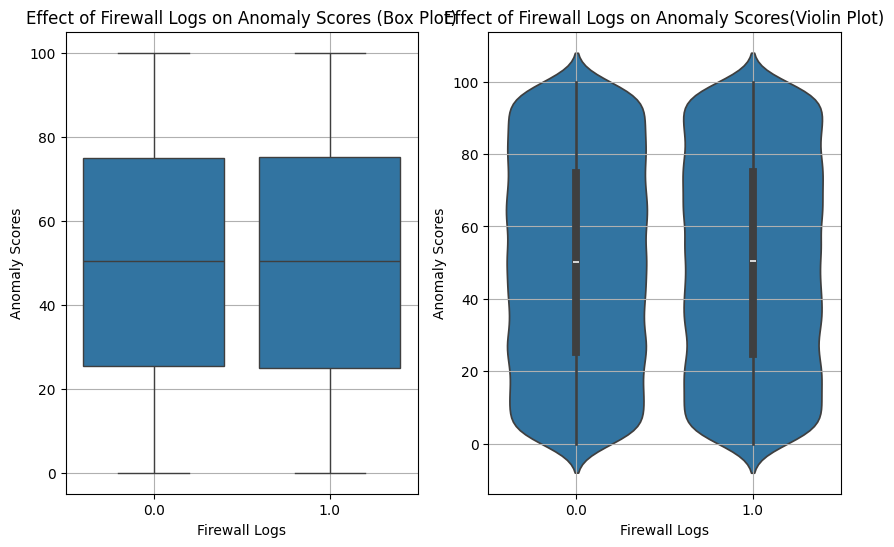

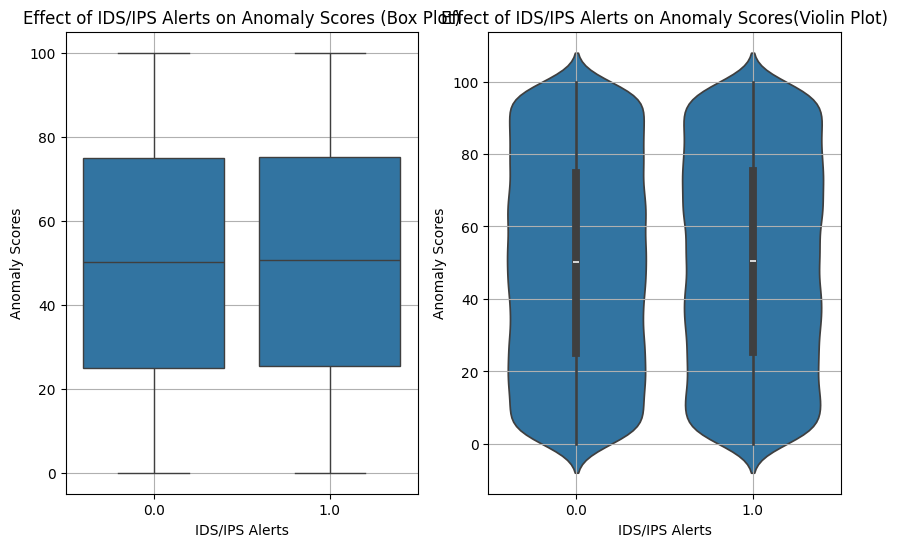

In [13]:
plot_correlation(df,'Malware Indicators')
plot_correlation(df,'Alerts/Warnings')
#plot_correlation(df,'Proxy Information')
plot_correlation(df,'Firewall Logs')
plot_correlation(df,'IDS/IPS Alerts')

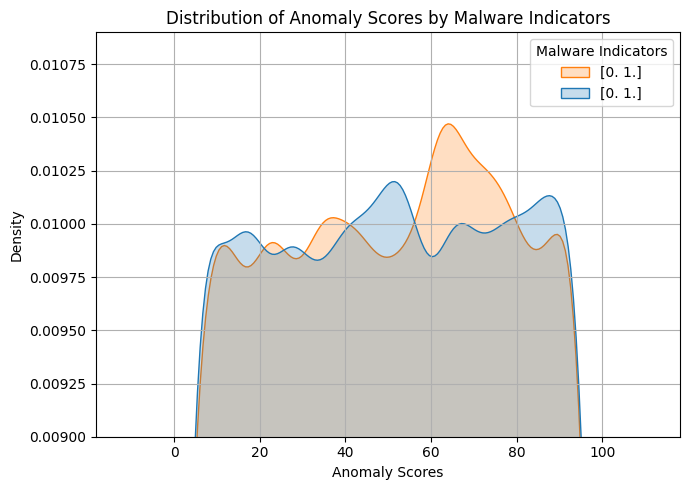

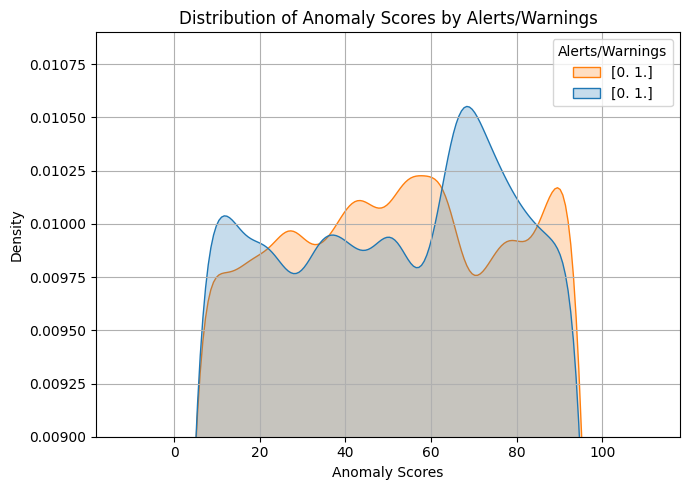

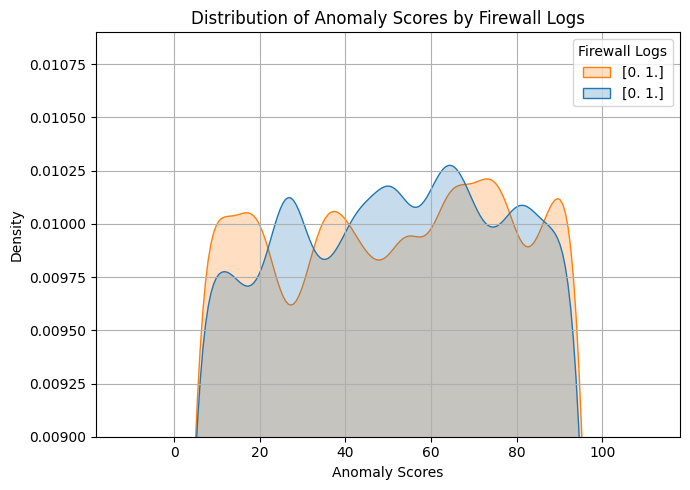

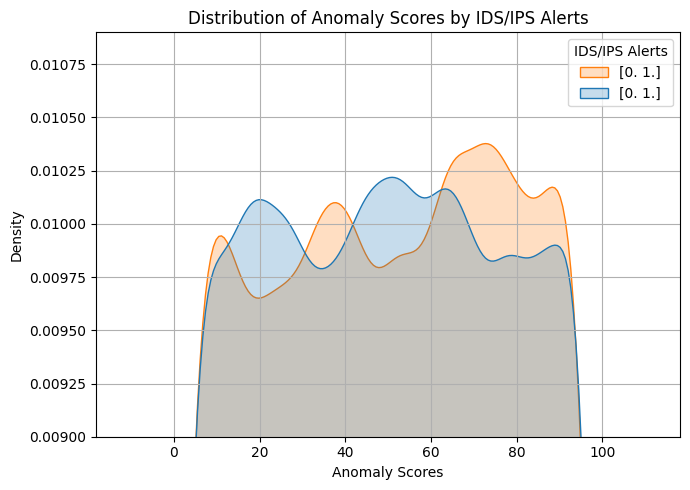

In [32]:
none_cols = ['Malware Indicators','Alerts/Warnings','Firewall Logs','IDS/IPS Alerts']

for col in none_cols:
    plot_features_vals_density(df,col)

## Handling Categorical Features

In [49]:
print(df.head())

             Timestamp Source IP Address Destination IP Address  Source Port  \
0  2023-05-30 06:33:58     103.216.15.12           84.9.164.252        31225   
1  2020-08-26 07:08:30    78.199.217.198         66.191.137.154        17245   
2  2022-11-13 08:23:25      63.79.210.48          198.219.82.17        16811   
3  2023-07-02 10:38:46     163.42.196.10        101.228.192.255        20018   
4  2023-07-16 13:11:07     71.166.185.76        189.243.174.238         6131   

   Destination Port Protocol  Packet Length Packet Type Traffic Type  \
0             17616     ICMP            503        Data         HTTP   
1             48166     ICMP           1174        Data         HTTP   
2             53600      UDP            306     Control         HTTP   
3             32534      UDP            385        Data         HTTP   
4             26646      TCP           1462        Data          DNS   

                                        Payload Data  ...  Action Taken  \
0  Qui natu

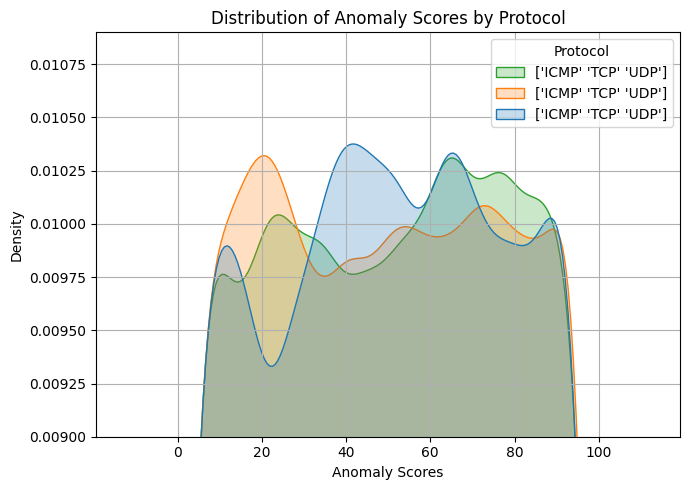

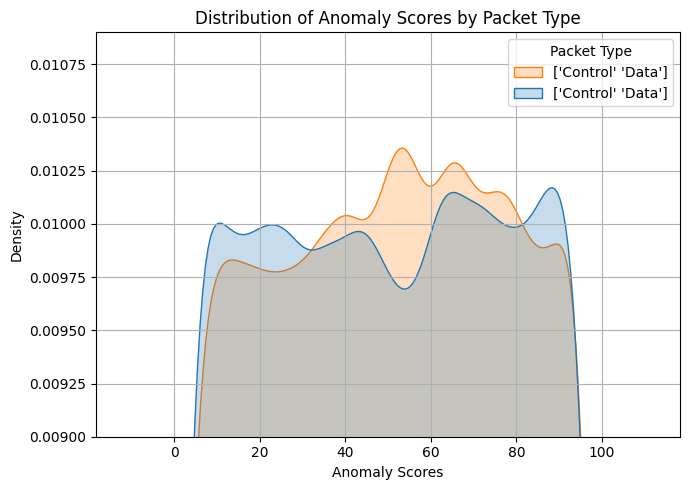

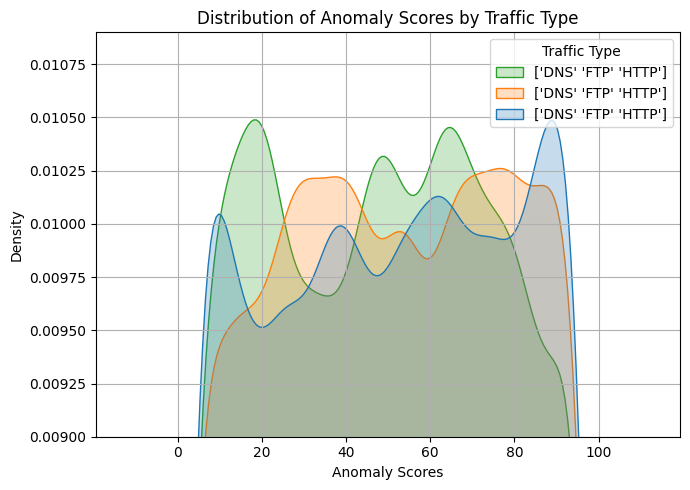

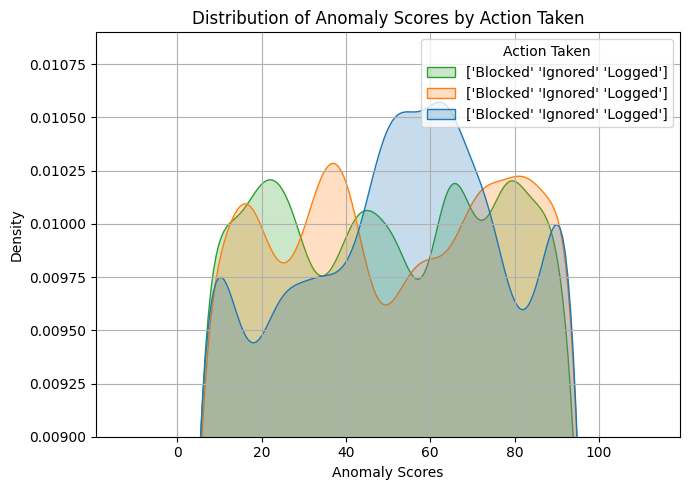

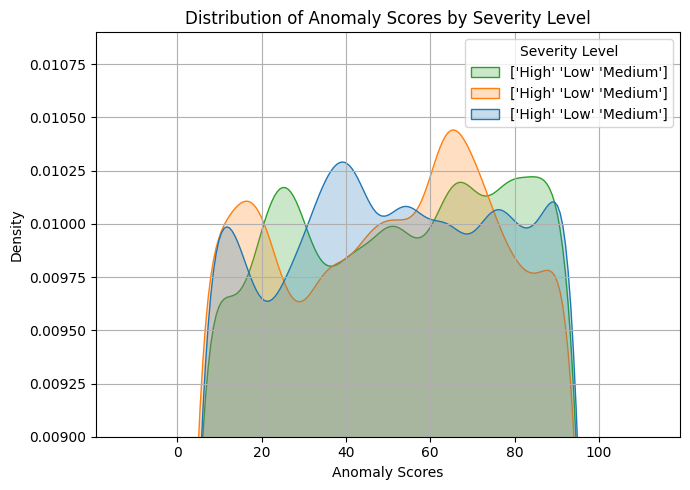

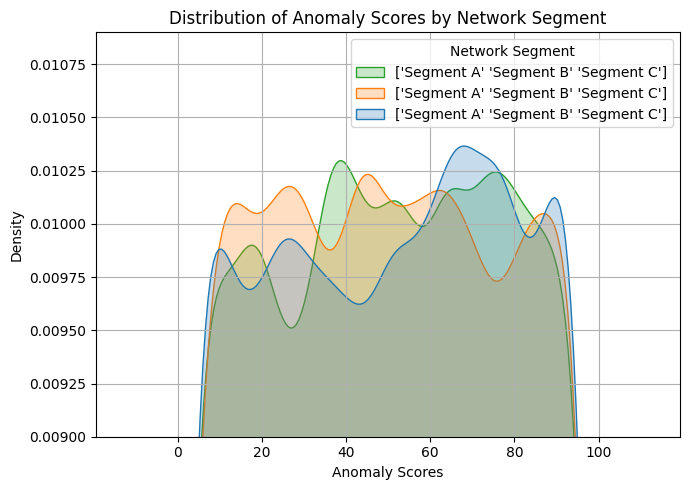

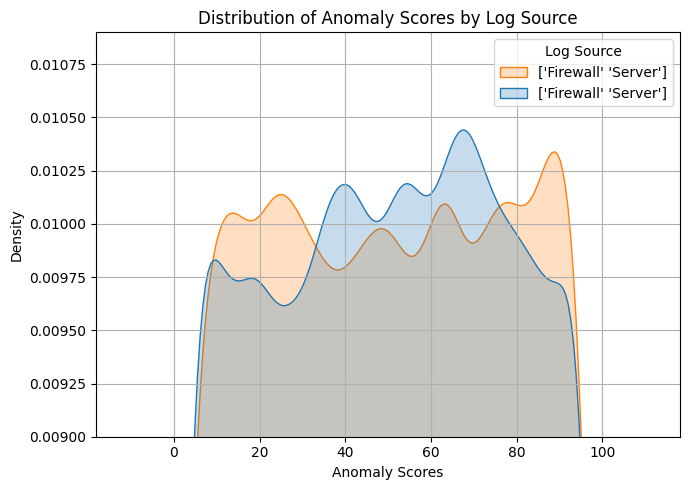

In [124]:
cat_cols = ['Protocol', 'Packet Type','Traffic Type','Action Taken','Severity Level','Network Segment','Log Source']
for col in cat_cols:
    plot_features_vals_density(df,col)


In [51]:
df['User Information'].value_counts() # unnecessary, drop

User Information
Ishaan Chaudhari    6
Heer Lad            6
Ishita Chaudry      5
Yasmin Ghose        5
Tara Madan          5
                   ..
Mohanlal Date       1
Indrans Randhawa    1
Uthkarsh Baria      1
Miraya Dua          1
Zaina Kumar         1
Name: count, Length: 32389, dtype: int64

In [86]:
filtered_df = df[~df['Device Information'].str.contains('\(')]
filtered_df

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source


In [125]:
# split device information

df[['Device', 'Device Info.']] = df['Device Information'].str.split('\(', n=1, expand=True)
df.drop(columns=['Device Information'], inplace=True)
df['Device'].value_counts()

Device
Mozilla/5.0     31951
Opera/9.37.        67
Opera/9.89.        63
Opera/9.75.        59
Opera/8.37.        59
                ...  
Opera/9.21.        32
Opera/9.14.        32
Opera/9.82.        31
Opera/9.66.        31
Opera/9.43.        30
Name: count, Length: 181, dtype: int64

In [126]:
df[['Device Name', 'Device Version']] = df['Device'].str.split('/', n=1, expand=True)
df.drop(columns=['Device'], inplace=True)
df['Device Name'].value_counts()

Device Name
Mozilla    31951
Opera       8049
Name: count, dtype: int64

In [127]:
df['Device Version'].value_counts()

Device Version
5.0      31951
9.37.       67
9.89.       63
9.75.       59
8.37.       59
         ...  
9.21.       32
9.14.       32
9.82.       31
9.66.       31
9.43.       30
Name: count, Length: 181, dtype: int64

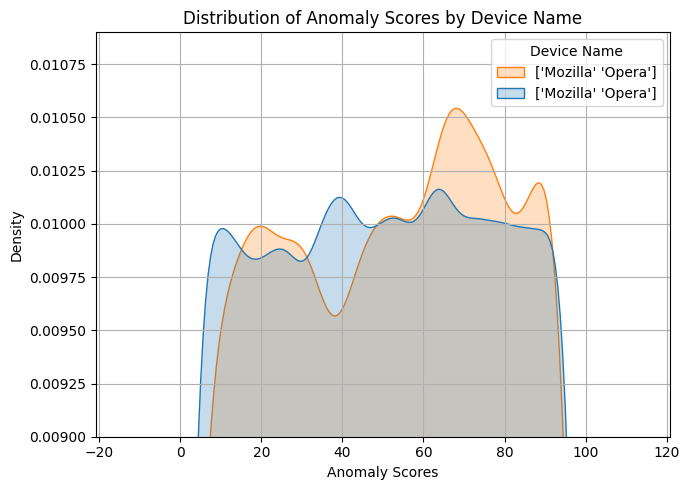

In [128]:
plot_features_vals_density(df,'Device Name')

In [110]:
df['Device Version'] = df['Device Version'].str.rstrip('.')
df['Device Version'] = pd.to_numeric(df['Device Version'], errors='coerce')

In [111]:
df['Device Version'].value_counts()

Device Version
5.00    31951
9.37       67
9.89       63
9.75       59
8.37       59
        ...  
9.21       32
9.14       32
9.82       31
9.66       31
9.43       30
Name: count, Length: 181, dtype: int64

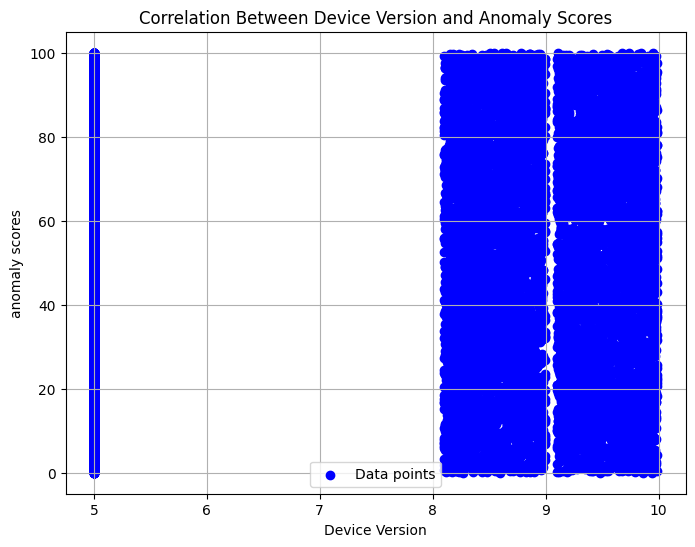

In [96]:
plot_scatter(df,'Device Version') # drop, unnecessary

In [112]:
df['Device Info.']

0        compatible; MSIE 8.0; Windows NT 6.2; Trident/...
1        compatible; MSIE 8.0; Windows NT 6.0; Trident/...
2        compatible; MSIE 9.0; Windows NT 6.2; Trident/...
3        Macintosh; PPC Mac OS X 10_11_5; rv:1.9.6.20) ...
4        compatible; MSIE 5.0; Windows NT 6.2; Trident/...
                               ...                        
39995    iPad; CPU iPad OS 14_2_1 like Mac OS X) AppleW...
39996    Windows; U; Windows 98; Win 9x 4.90) AppleWebK...
39997    Windows; U; Windows NT 4.0) AppleWebKit/533.2....
39998    X11; Linux i686) AppleWebKit/536.2 (KHTML, lik...
39999    iPod; U; CPU iPhone OS 3_0 like Mac OS X; tg-T...
Name: Device Info., Length: 40000, dtype: object

In [114]:
filtered_df = df[~df['Device Info.'].str.contains(';')]
filtered_df

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,User Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source,Device Info.,Device Name,Device Version
115,2023-08-11 07:44:05,24.22.149.26,146.21.102.253,13158,15042,UDP,491,Control,FTP,Unde enim porro voluptatem. Voluptatibus elige...,...,Nirvaan Sant,Segment C,"Phusro, Madhya Pradesh",NaN,NaN,NaN,Firewall,"Windows NT 5.0) AppleWebKit/534.0 (KHTML, like...",Mozilla,5.0
146,2021-06-30 00:40:16,159.102.43.101,34.167.108.175,46797,24409,ICMP,525,Data,HTTP,Commodi minima distinctio impedit inventore ap...,...,Divyansh Ramanathan,Segment B,"Nashik, Jharkhand",95.202.50.31,NaN,NaN,Firewall,"Windows CE) AppleWebKit/536.2 (KHTML, like Gec...",Mozilla,5.0
157,2020-06-08 07:02:00,203.33.240.253,56.220.194.14,15241,28035,TCP,418,Data,HTTP,Magnam corporis facilis. Repellat aspernatur t...,...,Lakshay Gaba,Segment A,"Danapur, Telangana",79.7.195.74,NaN,Alert Data,Server,"Windows 95) AppleWebKit/535.1 (KHTML, like Gec...",Mozilla,5.0
180,2022-09-27 09:40:00,30.29.44.104,55.210.48.133,24450,40274,TCP,1240,Data,DNS,Vero doloribus magni ea. Molestiae deserunt di...,...,Kabir Som,Segment A,"Ghaziabad, Punjab",95.178.16.77,Log Data,NaN,Firewall,"Windows NT 5.0) AppleWebKit/531.2 (KHTML, like...",Mozilla,5.0
209,2020-08-12 00:11:20,212.253.164.191,17.62.29.174,26735,50914,UDP,636,Control,FTP,Earum provident ratione praesentium necessitat...,...,Yakshit Devi,Segment B,"Mirzapur, Jharkhand",NaN,NaN,Alert Data,Firewall,"Windows NT 5.0) AppleWebKit/534.2 (KHTML, like...",Mozilla,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39947,2023-04-16 08:09:44,143.220.253.158,37.231.236.14,27646,17633,UDP,906,Data,DNS,Soluta quo excepturi iusto doloremque. Tempore...,...,Yasmin Amble,Segment A,"Mumbai, Rajasthan",NaN,NaN,Alert Data,Firewall,"Windows NT 6.2) AppleWebKit/532.2 (KHTML, like...",Mozilla,5.0
39962,2021-08-05 22:25:15,84.23.92.102,22.146.182.252,63579,3453,TCP,1237,Data,HTTP,Eaque quia a ratione. Tempore neque sunt facil...,...,Shalv Raja,Segment A,"Gorakhpur, Chhattisgarh",192.155.84.122,NaN,Alert Data,Firewall,"Windows CE) AppleWebKit/531.2 (KHTML, like Gec...",Mozilla,5.0
39964,2023-02-15 12:46:27,200.121.171.60,42.132.115.167,33155,38028,TCP,702,Control,HTTP,Nemo harum totam voluptates corporis tenetur d...,...,Nitara Sidhu,Segment C,"Tadipatri, Nagaland",NaN,NaN,Alert Data,Server,"Windows 95) AppleWebKit/533.2 (KHTML, like Gec...",Mozilla,5.0
39979,2020-10-19 10:03:07,209.70.190.115,189.175.162.204,5055,34008,UDP,657,Data,FTP,Corrupti occaecati ducimus modi incidunt corpo...,...,Jayant Doctor,Segment A,"Unnao, Assam",66.149.132.170,Log Data,NaN,Server,"Windows NT 6.0) AppleWebKit/535.2 (KHTML, like...",Mozilla,5.0


In [129]:
device_info0 = []
device_info1 = []

for row in df['Device Info.']:
    if ';' in row:
        info0, info1 = row.split(';', 1)
        device_info0.append(info0)
        device_info1.append(info1)
    else:
        device_info0.append('None')
        device_info1.append(row)

split_df = pd.DataFrame({'Device info0': device_info0, 'Device info1': device_info1})
df = pd.concat([df.drop(columns=['Device Info.']), split_df], axis=1)
print(df['Device info0'].value_counts())

Device info0
compatible       7995
X11              7171
Macintosh        5813
Windows          2677
iPod             2656
                 ... 
Android 2.3.2      19
Android 2.3        19
Android 2.2.2      16
Android 3.2.2      16
Android 4.1.2      15
Name: count, Length: 83, dtype: int64

In [131]:
print(df['Device info0'].value_counts().head(30))

Device info0
compatible         7995
X11                7171
Macintosh          5813
Windows            2677
iPod               2656
Linux              1669
iPhone             1567
iPad               1551
None               1512
Windows 98          999
Windows NT 4.0      476
Windows NT 6.2      451
Windows NT 5.1      451
Windows NT 5.2      434
Windows 95          433
Windows NT 6.1      431
Windows NT 5.0      427
Windows NT 10.0     426
Windows CE          423
Windows NT 5.01     413
Windows NT 6.0      405
Android 5.0.2        41
Android 4.4.4        41
Android 4.0.1        39
Android 2.3.6        37
Android 2.3.4        35
Android 11           35
Android 2.2          34
Android 5.0.1        33
Android 10           33
Name: count, dtype: int64


/var/folders/ms/lx6k291d71z8f387pwx9g8cm0000gn/T/ipykernel_1390/2337017160.py:31: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x='Anomaly Scores', hue=column, fill=True, common_norm=False, palette='tab10', ax=ax, label=vals_names)
/var/folders/ms/lx6k291d71z8f387pwx9g8cm0000gn/T/ipykernel_1390/2337017160.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


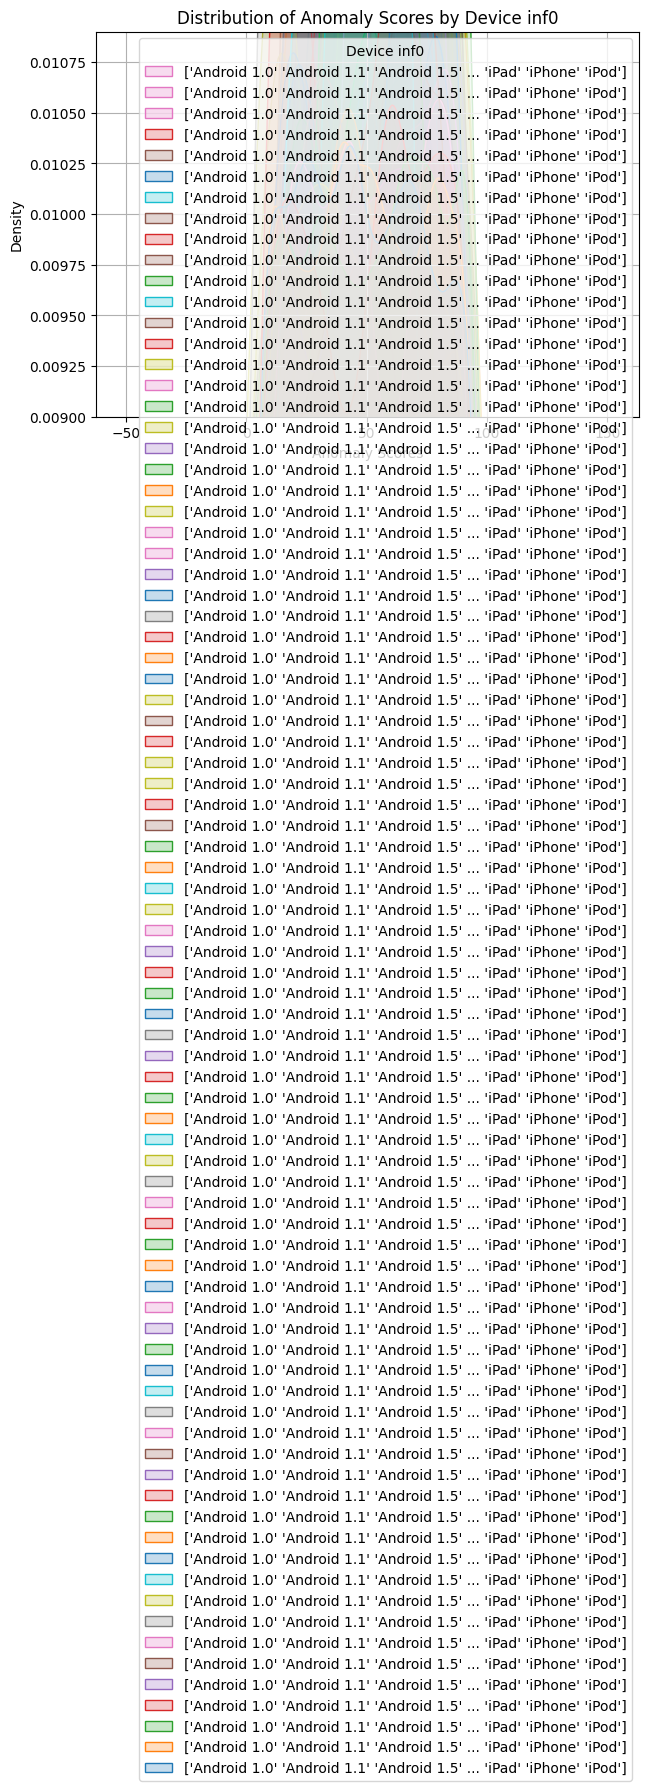

In [103]:
plot_features_vals_density(df,'Device inf0')

## Numerical Values

In [48]:
print(df.head())

             Timestamp Source IP Address Destination IP Address  Source Port  \
0  2023-05-30 06:33:58     103.216.15.12           84.9.164.252        31225   
1  2020-08-26 07:08:30    78.199.217.198         66.191.137.154        17245   
2  2022-11-13 08:23:25      63.79.210.48          198.219.82.17        16811   
3  2023-07-02 10:38:46     163.42.196.10        101.228.192.255        20018   
4  2023-07-16 13:11:07     71.166.185.76        189.243.174.238         6131   

   Destination Port Protocol  Packet Length Packet Type Traffic Type  \
0             17616     ICMP            503        Data         HTTP   
1             48166     ICMP           1174        Data         HTTP   
2             53600      UDP            306     Control         HTTP   
3             32534      UDP            385        Data         HTTP   
4             26646      TCP           1462        Data          DNS   

                                        Payload Data  ...  Action Taken  \
0  Qui natu

In [ ]:
plot_scatter(df,'Packet Length')
plot_scatter(df,'Packet Length')


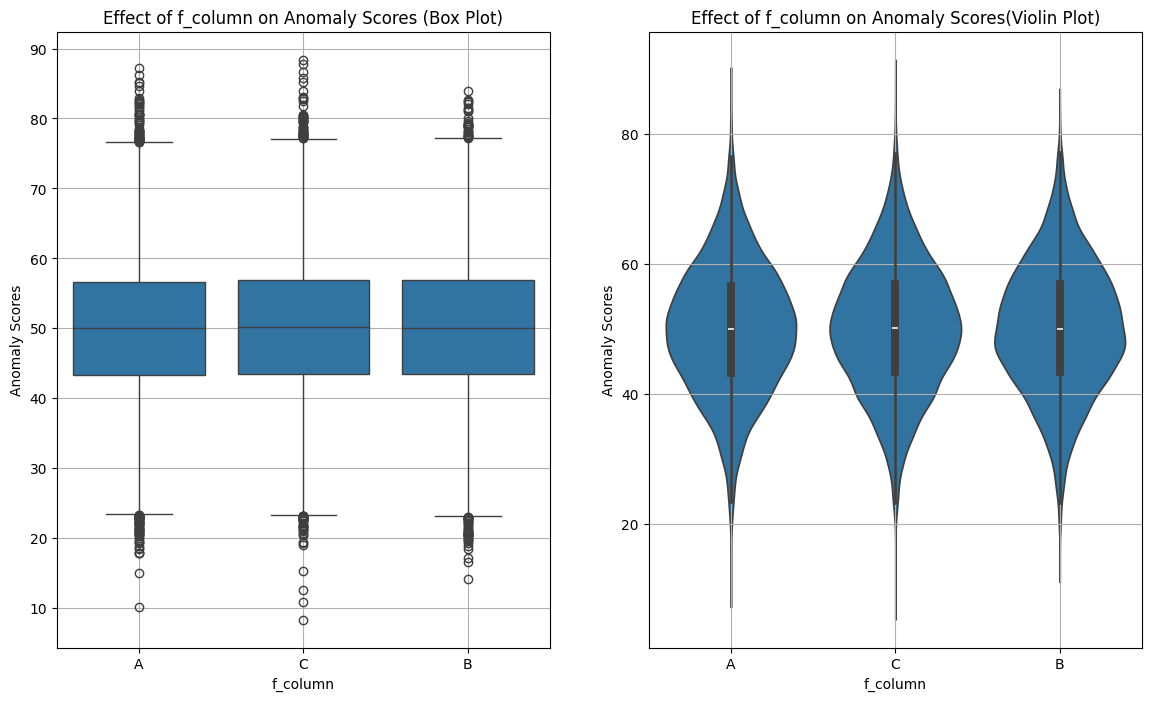

In [18]:
data = {
    'f_column': np.random.choice(['A', 'B', 'C'], size=40000),
    'Anomaly Scores': np.random.normal(loc=50, scale=10, size=40000)
}
test_df = pd.DataFrame(data)

plot_correlation(test_df, 'f_column')

In [28]:
df_clean = df.dropna().copy()
df_clean.loc[:, 'Date'] = pd.to_datetime(df_clean['Timestamp'])


In [29]:
df.head(20)

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,...,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",1,1.0,0.0,Server
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,...,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",0,1.0,0.0,Firewall
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,...,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",1,1.0,1.0,Firewall
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro l...,...,Blocked,Medium,Fateh Kibe,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; ...,Segment B,"Jaunpur, Rajasthan",0,0.0,1.0,Firewall
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi v...,...,Blocked,Low,Dhanush Chad,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,Segment C,"Anantapur, Tripura",1,0.0,1.0,Firewall
5,2022-10-28 13:14:27,198.102.5.160,147.190.155.133,17430,52805,UDP,1423,Data,HTTP,Repellat quas illum harum fugit incidunt exerc...,...,Logged,Medium,Zeeshan Viswanathan,Opera/8.58.(X11; Linux i686; nl-NL) Presto/2.9...,Segment C,"Aurangabad, Meghalaya",0,0.0,0.0,Server
6,2022-05-16 17:55:43,97.253.103.59,77.16.101.53,26562,17416,TCP,379,Data,DNS,Qui numquam inventore repellat ratione fugit o...,...,Ignored,High,Ehsaan Dalal,Opera/9.24.(X11; Linux i686; fa-IR) Presto/2.9...,Segment A,"Eluru, Manipur",0,1.0,0.0,Server
7,2023-02-12 07:13:17,11.48.99.245,178.157.14.116,34489,20396,ICMP,1022,Data,DNS,Amet libero optio quidem praesentium libero. E...,...,Logged,High,Yuvaan Dubey,Mozilla/5.0 (Macintosh; U; PPC Mac OS X 10_7_6...,Segment A,"Phagwara, Andhra Pradesh",1,1.0,1.0,Firewall
8,2023-06-27 11:02:56,49.32.208.167,72.202.237.9,56296,20857,TCP,1281,Control,FTP,Veritatis nihil amet atque molestias aperiam m...,...,Blocked,High,Zaina Iyer,Mozilla/5.0 (Macintosh; U; PPC Mac OS X 10_5_8...,Segment B,"Ambala, Tripura",0,1.0,1.0,Server
9,2021-08-15 22:29:04,114.109.149.113,160.88.194.172,37918,50039,UDP,224,Data,HTTP,Consequatur ipsum autem reprehenderit quae. Do...,...,Blocked,Medium,Mishti Chaudhuri,Mozilla/5.0 (Windows; U; Windows NT 6.0) Apple...,Segment A,"Rampur, Mizoram",1,0.0,0.0,Server


# Model

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestRegressor

In [20]:
categorical_features = ['Protocol', 'Packet Type', 'Traffic Type', 'Malware Indicators',
                         'Attack Type', 'Attack Signature', 'Action Taken', 'Network Segment', 'Alerts/Warnings','Severity Level']

numerical_features = ['Packet Length']

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

X= df [categorical_features + numerical_features]
y= df['Anomaly Scores']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor) , ('model', RandomForestRegressor(n_estimators=100))
])

In [21]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Protocol', 'Packet Type',
                                                   'Traffic Type',
                                                   'Malware Indicators',
                                                   'Attack Type',
                                                   'Attack Signature',
                                                   'Action Taken',
                                                   'Network Segment',
                                                   'Alerts/Warnings',
                                                   'Severity Level']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Packet Length'])])),
                ('model', RandomForestRegressor())])

In [22]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Protocol', 'Packet Type',
                                                   'Traffic Type',
                                                   'Malware Indicators',
                                                   'Attack Type',
                                                   'Attack Signature',
                                                   'Action Taken',
                                                   'Network Segment',
                                                   'Alerts/Warnings',
                                                   'Severity Level']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Packet Length'])])),
                ('model', RandomForestRegressor())])

In [23]:
pipeline.feature_names_in_

array(['Protocol', 'Packet Type', 'Traffic Type', 'Malware Indicators',
       'Attack Type', 'Attack Signature', 'Action Taken',
       'Network Segment', 'Alerts/Warnings', 'Severity Level',
       'Packet Length'], dtype=object)

In [24]:
cross_validate(pipeline, X_train, y_train, cv=5, scoring='r2', return_train_score=True)

{'fit_time': array([15.37802696, 15.75733185, 15.06257582, 15.47040319, 15.82499099]),
 'score_time': array([0.26228404, 0.24858284, 0.24123907, 0.25105381, 0.23952413]),
 'test_score': array([-0.06655973, -0.06811854, -0.07285982, -0.0610922 , -0.05642748]),
 'train_score': array([0.85041806, 0.84980941, 0.85152301, 0.84981642, 0.85064508])}

In [41]:
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)

900.5217728703432


# Visualizations

In [19]:
df = pd.read_csv('input/cybersecurity_attacks.csv', usecols=['Timestamp', 'Protocol', 'Packet Type',
                                                       'Traffic Type', 'Anomaly Scores','Attack Type','Severity Level'], parse_dates=['Timestamp'])

#Columns are then renamed to lowercase strings
df.columns = ['date',  'Protocol', 'Packet Type','Traffic Type','Anomaly Scores','Attack Type','Severity Level' ]

# create columns that extracted from day for pivot purpose
df['month'] = df.date.dt.month
df['year'] = df.date.dt.year
df['day'] = df.date.dt.day
df['weekdayName'] = df.date.dt.day_name() # df.date.dt.day_name()
df['weekday'] = df.date.dt.weekday
df['weekend'] = df.date.dt.weekday // 5 == 1


# Pivot table to display year 2020...2023 vs months
# aggfunc is count to show attack count on certain month in each year
all_month_year_df = pd.pivot_table(df, values='Attack Type',
                                   index=["month"],
                                   columns=["year"],
                                   fill_value=0,                                   
                                   aggfunc="count"
                                   )
named_index = [[calendar.month_abbr[i] if isinstance(i, int) else i for i in list(all_month_year_df.index)]] # name months
all_month_year_df = all_month_year_df.set_index(named_index)
all_month_year_df


year,2020,2021,2022,2023
Jan,814,858,883,823
Feb,830,788,807,807
Mar,906,902,925,945
Apr,825,865,884,847
May,904,874,909,908
Jun,889,929,928,863
Jul,880,904,950,889
Aug,904,898,905,908
Sep,877,909,843,853
Oct,905,891,897,296


In [18]:
# visualize only year 2023 by month
# grouping by year first
grouped2023 = df.groupby(['year'])
df2023 = grouped2023.get_group(2023) # jan 2023 ?
df2023 = df2023[['month','weekday','Attack Type']]

weekdf_2023_df = pd.pivot_table(df2023, values='Attack Type',
                                   index=["weekday"],
                                   columns=["month"],                                   
                                   aggfunc="count",                                   
                                   fill_value=0)
named_index_2 = [[calendar.day_name[i] if isinstance(i, int) else i for i in list(weekdf_2023_df.index)]] # name months
weekdf_2023_df = weekdf_2023_df.set_index(named_index_2)
weekdf_2023_df


C:\Users\vinyo\AppData\Local\Temp\ipykernel_36308\1709208445.py:4: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df2023 = grouped2023.get_group(2023) # jan 2023 ?


month,1,2,3,4,5,6,7,8,9,10
Monday,138,129,147,111,159,126,119,97,108,58
Tuesday,146,95,120,113,153,117,108,157,126,51
Wednesday,87,127,127,102,133,117,132,140,129,38
Thursday,102,116,147,106,118,111,107,127,118,38
Friday,103,122,160,113,131,148,127,128,137,26
Saturday,101,122,130,157,109,124,137,134,141,25
Sunday,146,96,114,145,105,120,159,125,94,60


Text(0.5, 1.0, 'Monthly Attack from 2023 to 2023 ')

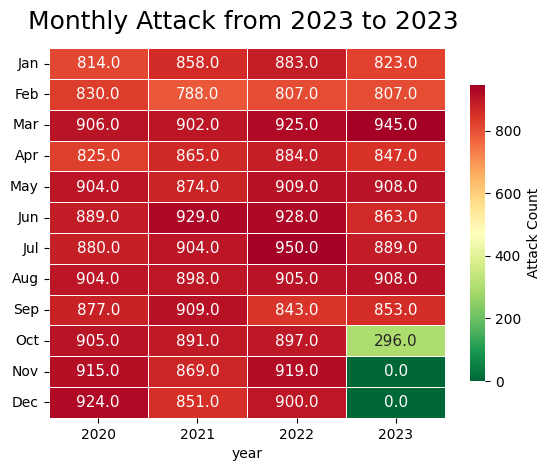

In [15]:
# display year vs months of 
ax = sns.heatmap(all_month_year_df, cmap='RdYlGn_r',
                 robust=True,
                 fmt='.1f',
                 annot=True,
                 linewidths=.5,
                 annot_kws={'size':11},
                 cbar_kws={'shrink':.8,
                           'label':'Attack Count'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.title('Monthly Attack from 2023 to 2023 ', fontdict={'fontsize':18},    pad=14)

Text(0.5, 1.0, 'Weekday total attack count 2020 to 2023')

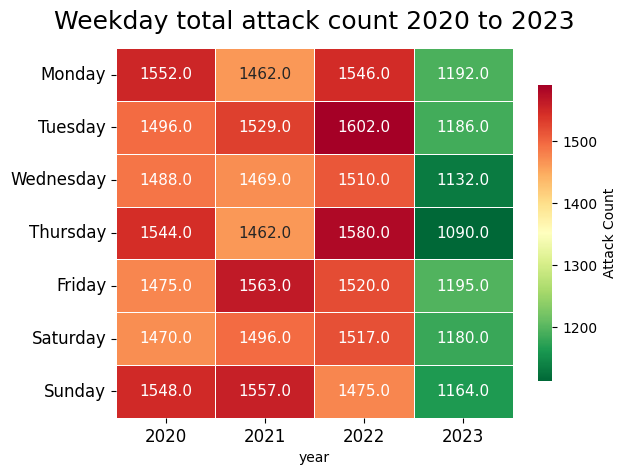

In [16]:
# generate pivot to show weekday vs year , each cell display attack count in a weekday whole year
weekdf_df = pd.pivot_table(df, values='Attack Type',
                                   index=["weekday"],
                                   columns=["year"],                                   
                                   aggfunc="count",                                   
                                   fill_value=0)
named_index_2 = [[calendar.day_name[i] if isinstance(i, int) else i for i in list(weekdf_df.index)]] # name months
weekdf_df = weekdf_df.set_index(named_index_2)
# Weekday total attack count in one year
ax = sns.heatmap(weekdf_df, cmap='RdYlGn_r',
                 robust=True,
                 fmt='.1f',
                 annot=True,
                 linewidths=.5,
                 annot_kws={'size':11},
                 cbar_kws={'shrink':.8,
                           'label':'Attack Count'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=12)
plt.title('Weekday total attack count 2020 to 2023', fontdict={'fontsize':18},    pad=14)